# Strating with a Simple Example: Digits Data from sklearn
Let's start our adventure into convolutional networks with a simple example of the digits dataset. This was not always such a simple example, but modern day computing power and open source tools has made it a significantly more tractable problem. 

In [16]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(0) # using this to help make results reproducible

digits = datasets.load_digits()
X = digits.data.astype(np.float32)/16.0 - 0.5
y = digits.target.astype(np.int32)

# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Split X_train again to create validation data
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)

X_train.shape

(1437, 64)

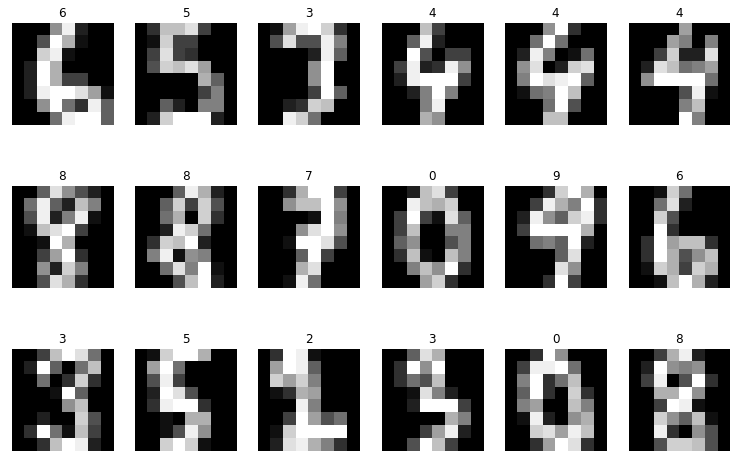

In [17]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, 8, 8) # defaults to showing a 3 by 6 subset of the images

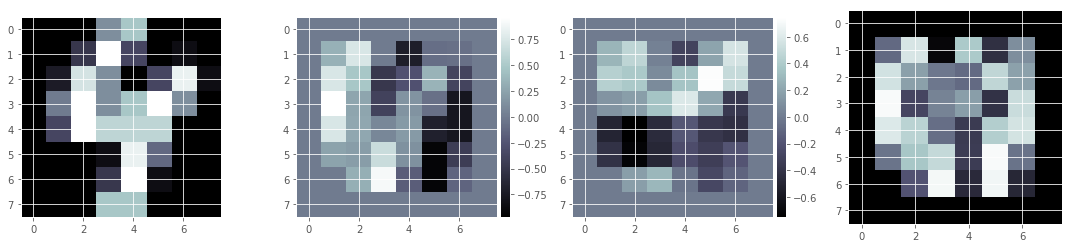

In [18]:
# A reminder of what convolution is
from skimage.io import imshow
from skimage.filters import sobel_h, sobel_v

plt.figure(figsize=(15,4))

idx_to_reconstruct = int(np.random.rand(1)*len(X))
img  = X[idx_to_reconstruct].reshape((8,8))

plt.subplot(1,4,1)
imshow(img,cmap='bone')

sv = sobel_v(img)
sh = sobel_h(img)

plt.subplot(1,4,2)
imshow(sv,cmap='bone')
plt.subplot(1,4,3)
imshow(sh,cmap='bone')

gradient_mag = np.sqrt(sv**2 + sh**2 ) 
plt.subplot(1,4,4)
imshow(gradient_mag,cmap='bone')


The above shows two separate convolutions of one digit using sobel filters (essentially vertical and horizontal edge detectors, derivative). The far image is the combined magnitudes of the sobel filters. Wouldn't it be great if we did not need to specify the correct filters? What if we could just let the weights of the convolution be found through neural netowrk training methods. 

Of course, we can. Let's do one example with a simple CNN architecture and compare it to the performance of a pixel wise MLP.

____
# A very Simple ConvNet Versus a Raw Pixel Input MLP
In general, the flattened images placed through a MLP can be quite accurate (as we have seen in the past). Even so, using convolitional filters and pooling should provide us with some better resilience to small perturbations in the images. 

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

keras.__version__

'2.0.2'

In [20]:
NUM_CLASSES = 10
print(X_train.shape)
print(X_test.shape)

(1437, 64)
(360, 64)


In [21]:
%%time

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=X_train.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

CPU times: user 13.3 s, sys: 6.49 s, total: 19.8 s
Wall time: 13.3 s


In [22]:
%%time

# make a CNN with conv layer and max pooling
cnn = Sequential()
cnn.add(Reshape((1,8,8), input_shape=(1,64)))
cnn.add(Conv2D(filters=16, kernel_size= (2, 2), padding='same', input_shape=(1,8,8)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
# add one layer on flattened output
cnn.add(Flatten())
cnn.add(Dense(NUM_CLASSES))
cnn.add(Activation('softmax'))

# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

CPU times: user 18.8 s, sys: 5.34 s, total: 24.1 s
Wall time: 15.3 s


In [23]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

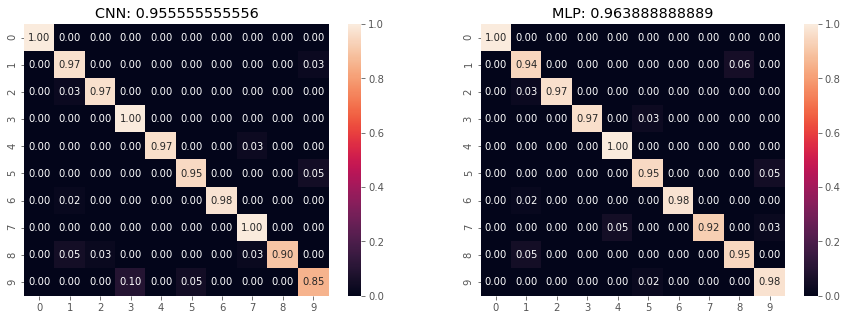

In [24]:
compare_mlp_cnn(cnn,mlp,X_test,y_test)

CPU times: user 21 s, sys: 7.02 s, total: 28 s
Wall time: 17.3 s


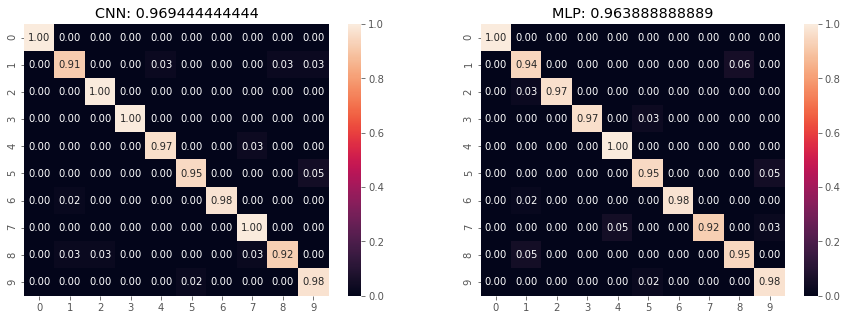

In [25]:
%%time

# changes: 
#    1. increased kernel size
cnn2 = Sequential()
cnn2.add(Reshape((1,8,8), input_shape=(1,64)))
cnn2.add(Conv2D(filters=16, kernel_size= (3, 3), padding='same', input_shape=(1,8,8)))
cnn2.add(Activation('relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
# add one layer on flattened output
cnn2.add(Flatten())
cnn2.add(Dense(NUM_CLASSES))
cnn2.add(Activation('softmax'))

# Let's train the model 
cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn2.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn2,mlp,X_test,y_test)

CPU times: user 38.6 s, sys: 9.01 s, total: 47.7 s
Wall time: 25.7 s


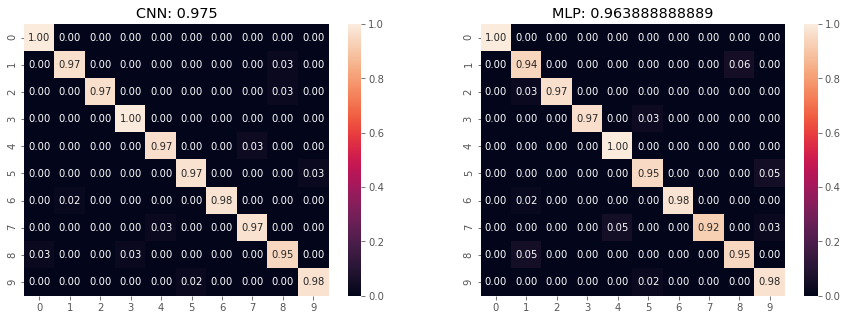

In [26]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer 
cnn3 = Sequential()
cnn3.add(Reshape((1,8,8), input_shape=(1,64)))

num_filt_layers = [32, 32]
for num_filters in num_filt_layers:
    cnn3.add(Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same'))
    cnn3.add(Activation('relu'))
    cnn3.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn3.add(Flatten())
cnn3.add(Dense(NUM_CLASSES))
cnn3.add(Activation('softmax'))

# Let's train the model 
cnn3.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn3.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn3,mlp,X_test,y_test)

CPU times: user 39.9 s, sys: 9.23 s, total: 49.1 s
Wall time: 26.9 s


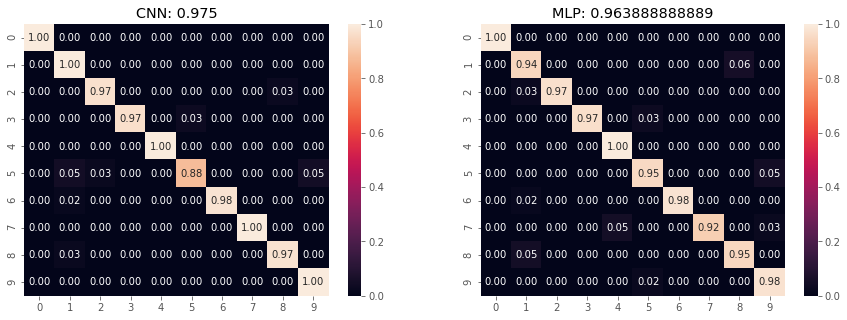

In [28]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer with increasing num filters
#    3. add more layers once flattened
cnn4 = Sequential()
cnn4.add(Reshape((1,8,8), input_shape=(1,64)))

num_filt_layers = [24, 48]
for num_filters in num_filt_layers:
    cnn4.add(Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn4.add(Flatten())
cnn4.add(Dense(100))
cnn4.add(Activation('relu'))
cnn4.add(Dense(NUM_CLASSES))
cnn4.add(Activation('softmax'))

# Let's train the model 
cnn4.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn4.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn4,mlp,X_test,y_test)

# MNIST
Okay, so we are honing in on the best performance for the digits data. But, we really need something a bit bigger to work on. Enter: MNIST. We have already used this dataset in the past, where we got about 97% accuracy with our custom MLP. Lets see how well Keras and tensorflow can perform!

In [29]:
# more data for handwriting recognition?
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
# from sklearn.preprocessing import RobustScaler
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images.astype(np.float32), labels.reshape((-1,1)).astype(np.int32)

X_train, y_train = load_mnist('data/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('data/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

X_train = X_train/255.0-0.5
X_test = X_test/255.0-0.5

NUM_CLASSES = 10

y_train.shape

Rows: 60000, columns: 784
Rows: 10000, columns: 784


(60000, 1)

In [30]:
%%time

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=X_train.shape[1], units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1)

Epoch 1/15
60000/60000 [==============================] - 7s - loss: 0.3545 - acc: 0.8909        

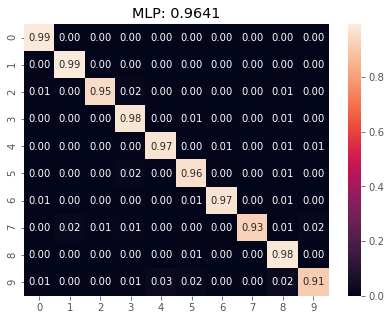

In [31]:
compare_mlp_cnn(None,mlp,X_test,y_test)

Epoch 1/15
60000/60000 [==============================] - 17s - loss: 0.0162 - acc: 0.8895      

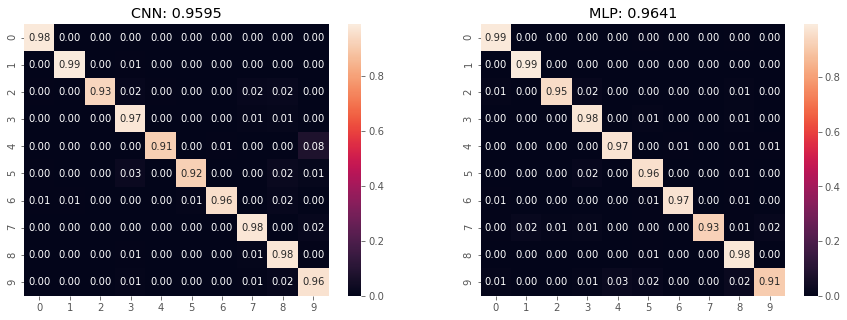

In [32]:
%%time

img_wh = 28 # width and height of MNIST images

# changes: 
#    1. Baseline: 2 conv layers and two output layers
cnn1 = Sequential()
cnn1.add(Reshape((1,img_wh, img_wh), input_shape=(1,img_wh**2)))

num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add(Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same'))
    cnn1.add(Activation('relu'))
    cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn1.add(Flatten())
cnn1.add(Dense(100, activation='relu'))
cnn1.add(Dense(100, activation='relu'))
cnn1.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn1.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1)

compare_mlp_cnn(cnn1,mlp,X_test,y_test)

In [ ]:
%%time
# Copy TensorFlow Architecture from 
#   Deep MNIST for experts
#   https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

# Manipulated to mirror parts of this network:
#   http://ankivil.com/mnist-database-and-simple-classification-networks/

cnn2 = Sequential()
cnn2.add(Reshape((1,img_wh, img_wh), input_shape=(1,img_wh**2)))

num_filt_layers = [32, 64]
for num_filters in num_filt_layers:
    cnn2.add(Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu')) # more compact syntax

    # max pooling
    cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn2.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn2.add(Flatten())
cnn2.add(Dense(1024, activation='relu'))
cnn2.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn2.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn2.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1,
        validation_data=(np.expand_dims(X_test, axis=1),y_test_ohe))



Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 32s - loss: 0.3057 - acc: 0.9042 - val_loss: 0.1161 - val_acc: 0.9618

In [ ]:
compare_mlp_cnn(cnn2,mlp,X_test,y_test)

In [86]:
cnn2.evaluate(np.expand_dims(X_test, axis=1),y_test_ohe)

 9952/10000 [============================>.] - ETA: 0s

[0.04149025030447228, 0.9869]

In [104]:
# want to save this model for later?
cnn2.save('large_data/mnist_cnn.h5')

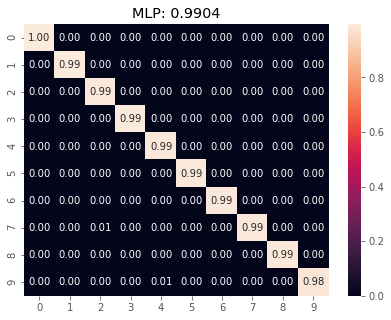

In [37]:
from keras.models import load_model

cnn_mnist = load_model('large_data/mnist_cnn.h5')
compare_mlp_cnn(None,cnn_mnist,np.expand_dims(X_test.reshape((-1,img_wh,img_wh))+0.5, axis=3),y_test)